In [45]:
import healpy as hp
import lunarsky
import matplotlib.pyplot as plt
import pyradiosky
import pyuvdata
import pyuvsim
import numpy as np
import uvtools

fatal: No names found, cannot describe anything.


## Load 21cm models

In [2]:
# def z_to_nu(z):
#     nu_0 = 1420405751.768  # Hz
#     return nu_0 / (z+1)

# redshifts = np.loadtxt('z_EIGSEP.txt')
# freqs_models = z_to_nu(redshifts) / 1e9  # GHz
# models = np.loadtxt('T21_EIGSEP.txt') / 1e3  # mK to K

# freqs_models = freqs_models[::-1]
# models = models[:, ::-1]

In [3]:
# # load standard models
# ares_models = np.load('models_21cm.npz')
# ares_T21 = ares_models['models'] / 1e3  # mK to K
# ares_freqs = ares_models['freqs']

## Import Beams

In [4]:
uvb_path = "../luseesky/uvbeams/003/"
fname = "RadiatedElectricField_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_Phase+0deg.uvbeam"

uvb=pyuvdata.UVBeam()
uvb.read_beamfits(uvb_path + fname)

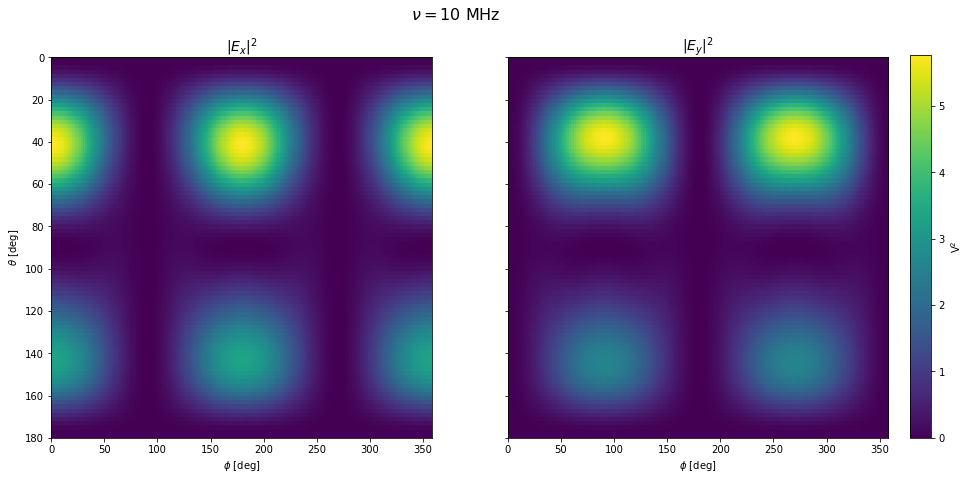

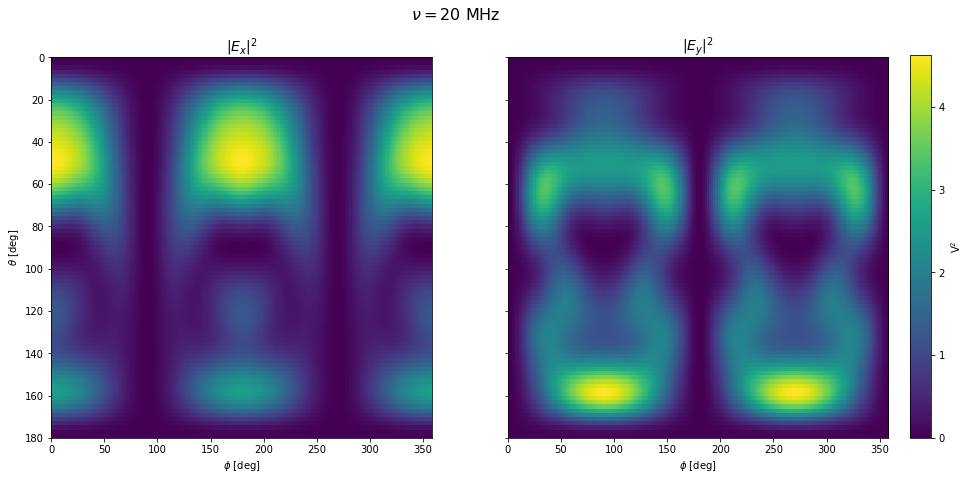

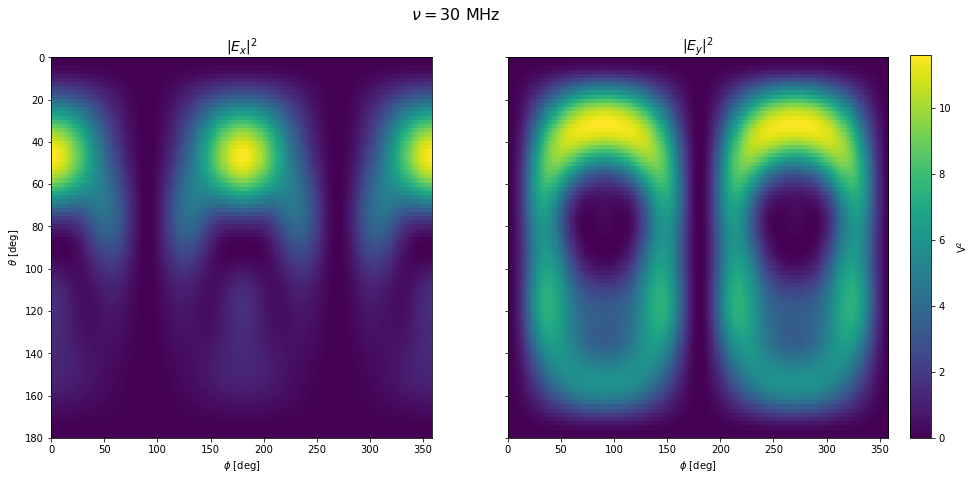

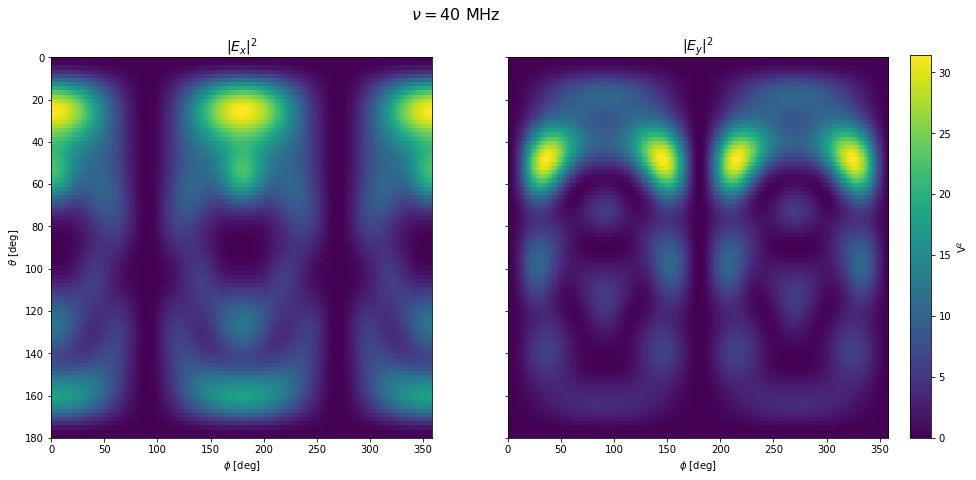

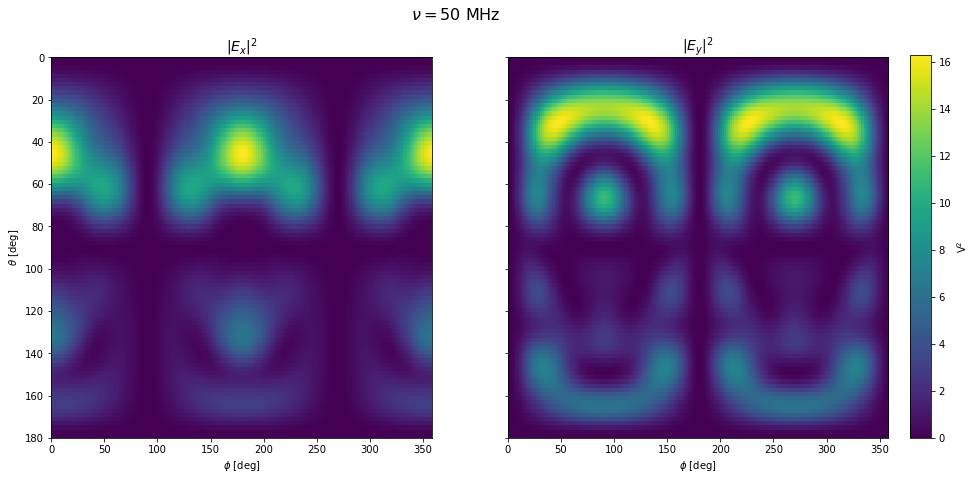

In [5]:
left, right = np.degrees(uvb.axis1_array).min(), np.degrees(uvb.axis1_array).max()
top, bottom = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
extent = [left, right, bottom, top]
components = ["$|E_x|^2$", "$|E_y|^2$"]

for freq in [10, 20, 30, 40, 50]:
    find = np.argmin(np.abs(uvb.freq_array[0] - freq*1e6))
    fig, axs = plt.subplots(figsize=(15,7), ncols=2, sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        im = ax.imshow(np.abs(uvb.data_array[i, 0, i, find])**2, interpolation="none", aspect="auto", extent=extent)
        ax.set_xlabel("$\\phi$ [deg]")
        if i == 0:
            ax.set_ylabel("$\\theta$ [deg]")
        ax.set_title(components[i], fontsize=14)
    cax=fig.add_axes([0.92, 0.125, .02, .76])
    plt.colorbar(im, cax, label="$\\rm{V}^2$")
    plt.suptitle('$\\nu={:.0f}$ MHz'.format(uvb.freq_array[0, find]/1e6), fontsize=16)
    plt.show()

## Load skymodel

In [6]:
# uvsim can read source catalogs, how does that link to skymaps?
# sol might be here: https://github.com/RadioAstronomySoftwareGroup/pyradiosky/blob/main/pyradiosky/skymodel.py
# https://arxiv.org/pdf/2104.03170.pdf (ULSA)

# in the meantime we use some sources at the moon zenith

In [7]:
loc = lunarsky.MoonLocation(lon=0.6875, lat=24.433, height=0)
skymodel = pyuvsim.simsetup.create_mock_catalog(2459630., arrangement="zenith", array_location=loc, Nsrcs=10,
                                                save=False)

In [8]:
skymodel[0].write_skyh5("../sim_files/mock_zenith.skyh5", clobber=True)

File exists; clobbering.


## Run UVSim

In [9]:
# this does the same as pyuvsim/scripts/run_param_pyuvsim.py
# optional: pyuvsim profiler?
uvdata = pyuvsim.uvsim.run_uvsim("../sim_files/obsparam.yaml", return_uv=True, quiet=False)

All polarized beams have x_orientation set to None. This will make it hard to interpret the polarizations of the simulated visibilities.


UVData initialization took 0.007 min
Skymodel setup took 0.000 min
Nbls: 1
Ntimes: 256
Nfreqs: 50
Nsrcs: 10
Tasks:  12800.0
1.00% completed. 0:00:00.475986  elapsed. 0:00:47.122614 remaining. 

2.00% completed. 0:00:00.724202  elapsed. 0:00:35.485882 remaining. 

3.00% completed. 0:00:00.892045  elapsed. 0:00:28.842804 remaining. 

4.00% completed. 0:00:01.061974  elapsed. 0:00:25.487371 remaining. 

5.00% completed. 0:00:01.228538  elapsed. 0:00:23.342218 remaining. 

6.00% completed. 0:00:01.399865  elapsed. 0:00:21.931217 remaining. 

7.00% completed. 0:00:01.568797  elapsed. 0:00:20.842590 remaining. 

8.00% completed. 0:00:01.737790  elapsed. 0:00:19.984586 remaining. 

9.00% completed. 0:00:01.908147  elapsed. 0:00:19.293487 remaining. 

10.00% completed. 0:00:02.073954  elapsed. 0:00:18.665589 remaining. 

11.00% completed. 0:00:02.242450  elapsed. 0:00:18.143461 remaining. 

12.00% completed. 0:00:02.408628  elapsed. 0:00:17.663268 remaining. 

13.00% completed. 0:00:02.578815 

In [64]:
## output is real ...
print(np.max(np.abs(uvdata.data_array.imag)))
print("Discarding imaginary part...")
uvdata.data_array = uvdata.data_array.real

3.469446951953614e-17
Discarding imaginary part...


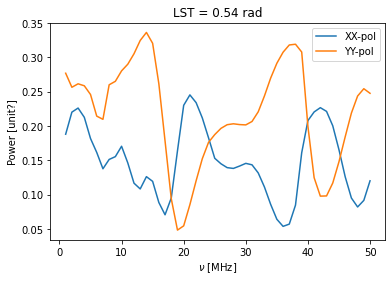

In [69]:
plt.figure()
plt.plot(uvdata.freq_array[0]/1e6, uvdata.data_array[0, 0, :, 0], label="XX-pol")
plt.plot(uvdata.freq_array[0]/1e6, uvdata.data_array[0, 0, :, 1], label="YY-pol")
plt.legend()
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Power [unit?]")
plt.title("LST = {:.2f} rad".format(uvdata.lst_array[0]))
plt.show()

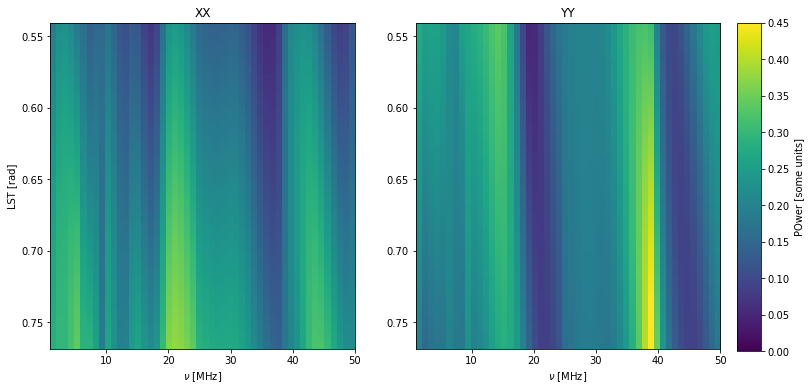

In [98]:
extent = [uvdata.freq_array[0].min()/1e6, uvdata.freq_array[0].max()/1e6, uvdata.lst_array.max(), uvdata.lst_array.min()]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
im = uvtools.plot.waterfall(uvdata.data_array[:, 0, :, 0], mode='abs', extent=extent)
im.set_clim(0, 0.45)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
im = uvtools.plot.waterfall(uvdata.data_array[:, 0, :, 1], mode='abs', extent=extent)
im.set_clim(0, 0.45)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="POwer [some units]")

## Compute eigenmodes

In [123]:
pols = ["XX", "YY"]

idata = uvdata.data_array[:, 0, :, :2]  # uncalibrated, nspws=0, no crosspols
d = idata - np.mean(idata, axis=0)  # subtract mean

V_full = np.empty((uvdata.freq_array[0].size, uvdata.freq_array[0].size, 2)) # eigenvector change of basis
for i, _ in enumerate(pols):  # compute for both XX and YY
    C = np.dot(d[:, :, i].T, d[:, :, i])  # covariance matrix
    U, S, V = np.linalg.svd(C)
    V_full[:, :, i] = V 

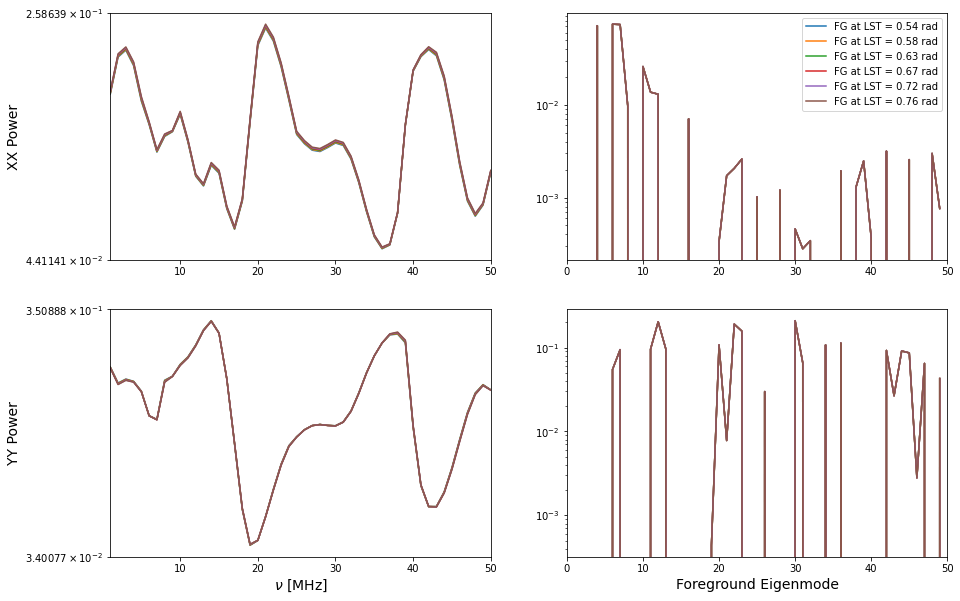

In [149]:
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

for i, lst in enumerate(uvdata.lst_array[::50]):
    axs[0, 0].plot(uvdata.freq_array[0]/1e6, np.abs(idata[i, :, 0]), label="FG at LST = {:.2f} rad".format(lst))
    axs[0, 1].plot(V_full[:, :, 0] @ idata[i, :, 0], label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 0].plot(uvdata.freq_array[0]/1e6, np.abs(idata[i, :, 1]), label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 1].plot(V_full[:, :, 0] @ idata[0, :, 1], label="FG at LST = {:.2f} rad".format(lst))

plt.setp(axs[:, 0], yscale="symlog", xlim=(uvdata.freq_array[0].min()/1e6, uvdata.freq_array[0].max()/1e6))
plt.setp(axs[:, 1], yscale="log", xlim=(0, len(V_full)))
axs[1, 0].set_xlabel("$\\nu$ [MHz]", fontsize=14)
axs[1, 1].set_xlabel("Foreground Eigenmode", fontsize=14)
for i, pol in enumerate(pols):
    axs[i, 0].set_ylabel(f"{pol} Power", fontsize=14)
axs[0, 1].legend()

plt.show()

## Calibrate / convert to K

In [17]:
# #### 
# # Calibration used by EIGSEP, do we still need this and which one?

# # old method
# # gain = beams[:,NPIX//2+1,NPIX//2+1]  # the center of the beam
# # avg = np.mean(data[-50:], axis=0) / gain  # average last 50 times ~ 4h40min
# # cal = 180 / avg[np.argmin(np.abs(freqs-0.180))]  # 180 MHz = 180 K

# # new method
# gain = 1
# avg = np.mean(data[-50:], axis=0) / gain  # avg of last 50 times, ~4h40m
# cal = 180 * (freqs/0.180)**(-2.5) / avg  # sky is 180 K at 180 MHz, assume power law with spectral index -2.5
# # alternatively, fit a power law to cal
# m, b = np.polyfit(np.log(freqs), np.log(cal), deg=1)
# cal_fit = np.exp(b)*freqs**m
# print(np.exp(b))
# print(m)  # spectral index

In [18]:
# fig = plt.figure()

# ax1 = fig.add_axes([0,0,1,1])
# fig.sca(ax1)
# plt.plot(np.log(freqs), np.log(cal), ls='--', label='Vivaldi')
# plt.plot(np.log(freqs), m*np.log(freqs)+b, ls='-', label='Vivaldi Fit')
# plt.plot(np.log(freqs), np.log(cal_dish), ls='--', label='Dish')
# plt.plot(np.log(freqs), md*np.log(freqs)+bd, ls='-', label='Dish Fit')
# plt.xlabel('$\\log{\\nu}$')
# plt.ylabel('log cal')
# vivaldi_text = 'spectral index = {:.2g}'.format(m.real)
# plt.text(-2.2, -15, vivaldi_text)
# dish_text = 'spectral index = {:.2g}'.format(md.real)
# plt.text(-2.2, -20, dish_text)

# ax2 = fig.add_axes([1.1,0,1,1])
# fig.sca(ax2)
# plt.plot(freqs, cal, ls='--', label='Vivaldi')
# plt.plot(freqs, cal_fit, ls='-', label='Vivaldi Fit')
# plt.plot(freqs, cal_dish, ls='--', label='Dish')
# plt.plot(freqs, cal_fit_d, ls='-', label='Dish Fit')
# plt.xlabel('$\\nu$')
# plt.ylabel('cal')
# plt.legend()

# plt.show()

In [112]:
# def gen_eor(A, nu0, w, tau):
#     B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
#     return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

# prms = {
#     'A': 0.52,
#     'nu0': 78.3e-3,
#     'w': 20.7e-3,
#     'tau': 6.5,
# }
# edges_eor = gen_eor(**prms)

# # idata = cal * data / gain + edges_eor  # use cal
# idata = cal_fit * data / gain + edges_eor  # use cal_fit

# plt.figure()

# for mdl in models:
#     plt.plot(freqs, 1e3*mdl)
# plt.plot(freqs, 1e3*fake_eor, 'k.-')
# plt.plot(freqs, idata[0], 'k:')  # foreground at some time

# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [mK]')
# plt.show()

In [111]:
# def dayenu(dat, width=1.):
#     _, rdat, _ = uvtools.dspec.fourier_filter(
#                                 x=uvdata.freq_array[0],  # hz
#                                 data=dat,
#                                 wgts=np.ones_like(dat),
#                                 mode='dpss_leastsq',
#                                 filter_centers=[0.],
#                                 filter_half_widths=[width * 1e-9],
#                                 eigenval_cutoff=[1e-12],
#                                 suppression_factors=[1e-9]
#     )
#     return rdat

# rdata = np.empty_like(uvdata.data_array[:, 0, :, :2], dtype=complex)  # NSPWS = 1, no crosspols
# rdata[:, :, 0] = dayenu(uvdata.data_array[:, 0, :, 0]/uvdata.data_array[55, 0, :, 0]) * uvdata.data_array[55, 0, :, 0]
# rdata[:, :, 1] = dayenu(uvdata.data_array[:, 0, :, 1]/uvdata.data_array[55, 0, :, 1]) * uvdata.data_array[55, 0, :, 1]

# assert np.allclose(rdata.imag, np.zeros_like(rdata.imag))
# rdata = rdata.real

In [119]:
idata = uvdata.data_array[:, 0, :, :2]  # uncalibrated, nspws=0, no crosspols
tint = uvdata.integration_time.mean()   # integration time, about 5-6 minutes
DF = np.mean(np.diff(uvdata.freq_array[0]))  # delta freq
noise = idata * np.random.randn(*idata.shape) / np.sqrt(DF * 1e9 * tint)  # shape: NTIMES, NFREQS, NPOLS

# Build a filter to exclude EoR from calibration signal
d = idata - np.mean(idata, axis=0)  # subtract mean
print(d.shape)
pols = ["XX", "YY"]
for i, _ in enumerate(pols):
    C = np.dot(d[:, :, i].T, d[:, :, i])
    U,S,V = np.linalg.svd(C)
    iS = np.identity(S.size)
    #iS[10:,10:] = 0
    iS[5:,5:] = 0
    Cinv = np.dot(V.T, np.dot(iS, U.T))

#pcal = idata[55] - 0.5 * fake_eor # XXX
pcal = np.dot(Cinv, idata[55]) # filter to exclude most of eor signal

reor = dayenu(edges_eor / pcal) * pcal
rmodels = dayenu(models / pcal) * pcal

idata_flattened = dayenu(idata / pcal) * pcal
noise_flattened = dayenu(noise / pcal) * pcal

(256, 50, 2)


ValueError: shapes (2,50,256) and (256,50,2) not aligned: 256 (dim 2) != 50 (dim 1)

In [118]:
noise.shape

(256, 50, 2)

In [21]:
# plt.figure()
# for mdl in rmodels:
#     plt.plot(freqs, 1e3*mdl)
# plt.plot(freqs, 1e3*reor, 'k.-')
# plt.plot(freqs, idata_flattened[0], 'k:')

In [22]:
# d = idata_flattened - np.mean(idata_flattened[-50:], axis=0)
# C = np.dot(d.T, d)
# U,S,V = np.linalg.svd(C)

# du = idata - np.mean(idata[-50:], axis=0)
# Cu = np.dot(du.T, du)
# Uu, Su, Vu = np.linalg.svd(Cu)

In [23]:
# m = rmodels - np.mean(rmodels, axis=0)
# Cm = np.dot(m.T, m)
# Um, Sm, Vm = np.linalg.svd(Cm)

In [53]:
uvdata.lst_array.shape

(256,)

In [43]:
uvdata.data_array.shape

(256, 1, 50, 4)

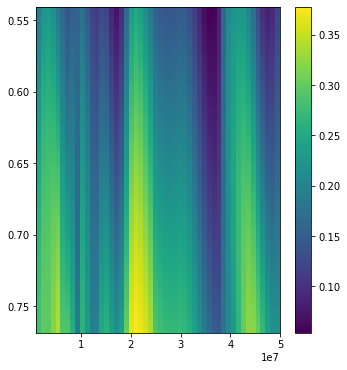

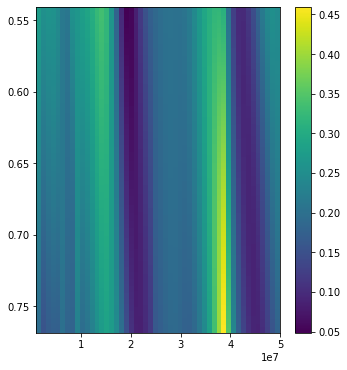

In [54]:
extent = [uvdata.freq_array[0].min()/1e6, uvdata.freq_array[0].max()/1e6, uvdata.lst_array.max(), uvdata.lst_array.min()]

plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(uvdata.data_array[:, 0, :, 0], mode='abs', extent=extent)
#plt.subplot(122)
#uvtools.plot.waterfall(np.dot(Vm, idata_flattened.T).T, mode='log')
_ = plt.colorbar()

plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(uvdata.data_array[:, 0, :, 1], mode='abs', extent=extent)
#plt.subplot(122)
#uvtools.plot.waterfall(np.dot(Vm, idata_flattened.T).T, mode='log')
_ = plt.colorbar()

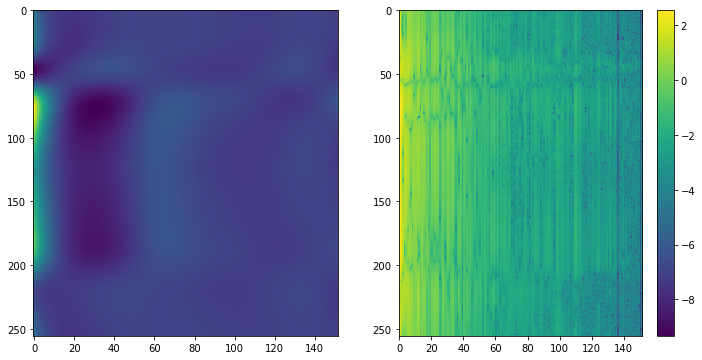

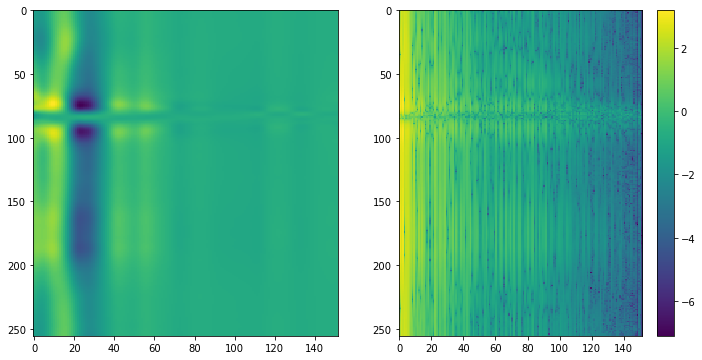

In [192]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata_flattened, mode='real')
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Vm, idata_flattened.T).T, mode='log')
_ = plt.colorbar()

plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata_flattened_dish, mode='real')
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Vmd, idata_flattened_dish.T).T, mode='log')
_ = plt.colorbar()

In [55]:
# plt.figure()
# print(rmodels.shape)
# #plt.semilogy(np.abs(np.dot(V, rmodels[78:79].T))**2)
# plt.semilogy(np.abs(np.dot(V, reor)),'r')
# #plt.semilogy(S, 'k.-')
# plt.semilogy(np.abs(np.dot(V, (idata_flattened[55:] - reor).T)), 'k:')
# #plt.semilogy(np.abs(np.dot(V, (idata[-50:]).T))**2, 'r:')
# plt.grid()
# plt.xlim(0)
# plt.show()

In [56]:
# dot_matrix = np.zeros((len(freqs), len(freqs)))
# for i in range(dot_matrix.shape[0]):
#     for j in range(dot_matrix.shape[1]):
#         dot_matrix[i, j] = Vm[i] @ V[j] * np.sqrt( Sm[i])

In [57]:
# fig = plt.figure()
# h_gap = 0.04
# axarr=[fig.add_axes([0.1, 0.1, .4-h_gap/2, .8])]


# plt.sca(axarr[0])
# l3 = plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, ::10], lw=1, alpha=.1, color='grey')
# x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reord).T))
# threshold_fg = np.where(x < x.max()*1e-4)[0].min()
# l0 = plt.semilogy(x, 'k-', lw=4)
# l1 = plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
# l2 = plt.axhline(np.mean(np.abs(np.dot(Vd, (noise_flattened[np.argmin(np.mean(idata_flattened, axis=1))]).T))),
#              ls='--', color='green', lw=4)
# #index_tm4 = np.argmin(np.dot(V, ))
# plt.axvline(threshold_fg, color='r', ls='--')
# plt.grid()
# #plt.gca().set_xticklabels([])
# plt.gca().tick_params(labelsize=16)
# plt.ylim(1e-3, 1e4)
# plt.xlim(0)
# plt.xlabel('Eigenvector Number', fontsize=18)
# plt.ylabel('Component Amplitude [K]', fontsize=18)


# plt.legend((l0, l1, l2, l3), ('Foregrounds and Beam', 'EDGES', 'Thermal Noise', '21cm Models'))
# plt.grid()
# plt.gca().tick_params(labelsize=16)
# #plt.axvline(threshold_fg_d, color='r', ls='--')

# plt.ylim(1e-3, 1e4)
# plt.xlim(0)
# plt.gca().set_yticklabels([])
# #plt.gca().set_xticklabels([])
# plt.xlabel('Eigenvector Number', fontsize=18)

# threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
# plt.gcf().set_size_inches(14, 7)

# #plt.savefig('pc_plot.png', bbox_inches='tight')

In [58]:
# idx_over = 12
# models_fg_ratio = np.abs(np.dot(V, rmodels.T))[idx_over] / x[idx_over]
# model_indices_above = np.where(models_fg_ratio > 2)[0]
# #max_above = np.max(models_above)
# print(len(model_indices_above))

/home/christian/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/christian/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


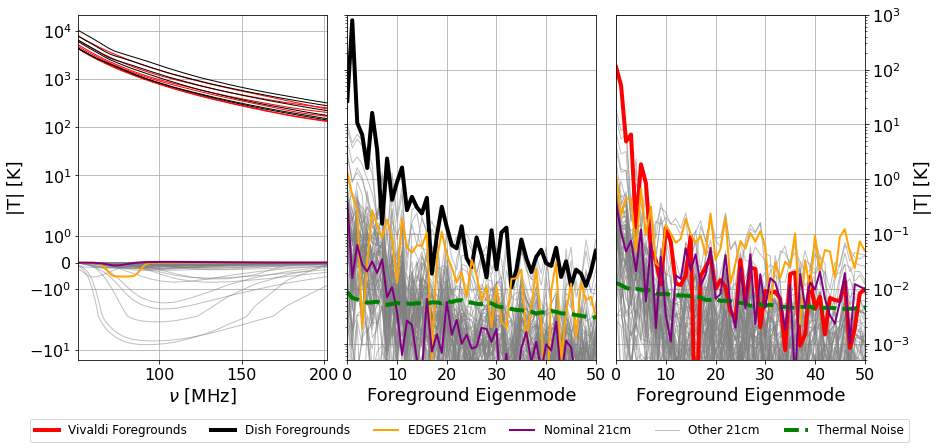

In [220]:
MODEL_NUMBER = model_indices_above[5]  # nominal model
edges_lw = 2.  # line width
ylim_for_log = (5e-4, 1e3)

fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([.8/3+.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([2*.8/3+.1, 0.2, .8/3-h_gap/2, .8])]

# freq basis
plt.sca(axarr[0])
l0, = plt.plot(freqs * 1e3, np.abs(idata[::50] - reor).T, color='r', lw=1, ls='-')  # fg
l2, = plt.plot(freqs * 1e3, models.T[:, :100][:, ::2], lw=1, alpha=.5, color='grey')  # models
_ = plt.plot(freqs * 1e3, models.T[:, 100:][:, ::50], lw=1, alpha=.5, color='grey')  # models cont.
l3, = plt.plot(freqs * 1e3, edges_eor, color='orange', lw=edges_lw)  # edges
l5, = plt.plot(freqs*1e3, models[MODEL_NUMBER], lw=2, color='purple')  # nominal model

plt.yscale('symlog')
plt.ylabel('|T| [K]', fontsize=18)
plt.grid()
#plt.ylim(1e-3, 5e3)
plt.xlim(freqs.min()*1e3, freqs.max()*1e3)
plt.gca().tick_params(labelsize=16)
plt.xlabel("$\\nu$ [MHz]", fontsize=18)

# eigenmode basis
plt.sca(axarr[2])
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, :100][:, ::2], lw=1, alpha=.5, color='grey')
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, 100:][:, ::50], lw=1, alpha=.5, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(V.T @ np.diag(np.abs((idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ V))
plt.semilogy(x, 'r-', lw=4)
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=edges_lw)
plt.semilogy(noise_level, color='green', ls='--', lw=4)[0]
plt.semilogy(np.abs(V @ rmodels[MODEL_NUMBER]), lw=2, color='purple')

plt.grid()
plt.gca().tick_params(labelsize=16)
plt.ylim(*ylim_for_log)
plt.xlim(0, 50)
plt.xlabel('Foreground Eigenmode', fontsize=18)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.ylabel('|T| [K]', fontsize=18)


threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()

plt.gcf().set_size_inches(14, 6)


fig.legend((l0, l3, l5,l2, l4), ('Foregrounds', 'EDGES 21cm', 'Nominal 21cm', 'Other 21cm', 'Thermal Noise'), loc='lower center' ,ncol=6, fontsize=12)
#plt.savefig('./eigenmode_plot.png', bbox_inches='tight')
plt.show()

#plt.savefig('plots/pc_plot_w_frequency.png', bbox_inches='tight')